In [31]:
# Libraries
import os
import numpy as np
!conda install --yes pandas 
import pandas as pd

import cv2
!conda install --yes seaborn 
import seaborn as sns
#!conda install --yes patool 
#import patoolibdataloader
#patoolib.extract_archive('models.zip')

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import gc
import time
import copy
from tqdm import tqdm
from sklearn.utils import compute_class_weight
from PIL import Image
import math
from glob import glob


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [32]:
# Hyper parameters
#NN='Resnet' ##Choise the Neural Network CNN or Resnet 
NUM_CLASSES = 2 # Labels: 0 - Non IDC, 1 - IDC

#CNN
NUM_EPOCHS_CNN = 1
BATCH_SIZE_CNN  = 128
learning_rate_CNN = 0.002

#Resnet
NUM_EPOCHS_RESNET = 1
BATCH_SIZE_RESNET  = 128
learning_rate_RESNET  = 0.002
run_training = True
retrain = False
find_learning_rate = True

In [33]:
# Device configuration
#torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Quadro M4000'

In [34]:
x=[] # x coordinate of an image
SelectedImageData = []
y=[] # y coordinate of an image
ID=[] # ID of a patient
cl=[] # class (0 for non IDC, 1 for IDC)
target=[] # class
matrix = []
i = 0
imagePatches = glob('../IDC_regular_ps50_idx5/**/*.png', recursive=True)
print("ImagePatches length (Total number of images): ", len(imagePatches))
print("imagePatches[0] (Checking if we read the file name): ", imagePatches[0])

# Go over all the images and create a dataset csv file including: x coordinate, y coordinate, target(label: 0-non IDC, 1-IDC), ID - Patient ID
for img in imagePatches:
    # For each image path extract the data from the image name
    imagePatches1=imagePatches[i].split("/")
    imagePatches2=imagePatches1[-1].split("_")
    x=imagePatches2[2].split("x")
    x=x[1]
    y=imagePatches2[3].split("y")
    y=y[1]
    target=imagePatches2[4].split(".png")
    cl=target[0]
   
    if cl=='class0':
        cl=0
    elif cl=='class1':
         cl=1
    ID=imagePatches2[0]
    filename=imagePatches[i]
    SelectedImageData = [ID,x,y,filename,cl]
    column_names = ["patient_id","x","y","filename","target"]
    matrix.append(SelectedImageData)
    i=i+1

ImagePatches length (Total number of images):  277524
imagePatches[0] (Checking if we read the file name):  ../IDC_regular_ps50_idx5/12910/1/12910_idx5_x651_y201_class1.png


In [35]:
base_path = "../IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)

# Add fully defined column into the row
images_df = pd.DataFrame(matrix, columns = column_names)

In [36]:
print("Create csv file")
# Create the dataset csv
images_df.to_csv(r'dataset.csv', index = False) 

Create csv file


In [37]:
files = os.listdir("../IDC_regular_ps50_idx5/")
print("Number of folders (Patients): ", len(files))

Number of folders (Patients):  279


In [38]:
# read csv file and return the created dataset (cancer_perc - precent of cancer images per patinet)
dataset = pd.read_csv("dataset.csv", usecols=['patient_id', 'filename','target'])
cancer_perc = dataset.groupby("patient_id").target.value_counts()/ dataset.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()
print("cancer_perc:" ,cancer_perc)

cancer_perc: target             0         1
patient_id                    
8863        0.788560  0.211440
8864        0.710503  0.289497
8865        0.922753  0.077247
8867        0.901340  0.098660
8913        0.914136  0.085864
...              ...       ...
16568       0.658213  0.341787
16569       0.896142  0.103858
16570       0.408942  0.591058
16895       0.761589  0.238411
16896       0.902396  0.097604

[279 rows x 2 columns]


In [39]:
#Splitting data into train and test: 0.2 for test 0.8 for train
train, test = train_test_split(images_df, stratify=images_df.target, test_size=0.2,train_size=0.8)
print("Train length: %d Test length %d" %(len(train), len(test)))

Train length: 222019 Test length 55505


In [40]:
print(train.head())
#print(test)

       patient_id     x     y  \
245185      14192   901  2351   
27308        9083   701   901   
80151       16166   851  1051   
69839       10269  2201  1201   
107456       9347  1801   951   

                                                 filename  target  
245185  ../IDC_regular_ps50_idx5/14192/0/14192_idx5_x9...       0  
27308   ../IDC_regular_ps50_idx5/9083/0/9083_idx5_x701...       0  
80151   ../IDC_regular_ps50_idx5/16166/0/16166_idx5_x8...       0  
69839   ../IDC_regular_ps50_idx5/10269/0/10269_idx5_x2...       0  
107456  ../IDC_regular_ps50_idx5/9347/0/9347_idx5_x180...       0  


In [46]:
train_cnn = train[["filename","target"]]
test_cnn = test[["filename","target"]]

In [47]:
print(train_cnn.head())
#print(test_cnn)

                                                 filename  target
245185  ../IDC_regular_ps50_idx5/14192/0/14192_idx5_x9...       0
27308   ../IDC_regular_ps50_idx5/9083/0/9083_idx5_x701...       0
80151   ../IDC_regular_ps50_idx5/16166/0/16166_idx5_x8...       0
69839   ../IDC_regular_ps50_idx5/10269/0/10269_idx5_x2...       0
107456  ../IDC_regular_ps50_idx5/9347/0/9347_idx5_x180...       0


In [48]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [49]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [50]:
dataset_train = MyDataset(df_data = train_cnn, transform=trans_train)
dataset_test = MyDataset(df_data = test_cnn,transform=trans_test)

In [51]:
#loader_train = DataLoader(dataset = dataset_train, batch_size=BATCH_SIZE_CNN, shuffle=True, num_workers=0)
loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE_CNN, shuffle=True, drop_last=True)

loader_test = DataLoader(dataset = dataset_test, batch_size=BATCH_SIZE_CNN//2, shuffle=False, num_workers=0)
print("Interaction for train and test:")
print(len(loader_train), len(loader_test))

Interaction for train and test:
1734 868


In [52]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        #self.conv11 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2)
        #self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)            
        self.bn1 = nn.BatchNorm2d(32)
        #self.bn11 = nn.BatchNorm2d(16)
        #self.bn12 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        #x = self.pool(F.leaky_relu(self.bn11(self.conv11(x))))
        #x = self.pool(F.leaky_relu(self.bn12(self.conv12(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))   
        x = self.avg(x)       
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [89]:
# Train the model
def train_model(NUM_EPOCHS,learning_rate,loader_train,optimizer,criterion,model):
    print("Train started:")
    model.to(device)
    #model_Cnn.to(device)
    #criterion = nn.CrossEntropyLoss()
    # Loss and optimizer
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
    loss_array=[]
    x=[]
    Epoch_time=0
    Int100_time=0
    Int100_time1=np.zeros(1735) 
    total_step = len(loader_train)
    test_loss , test_accuracy = [], []
    for epoch in range(NUM_EPOCHS):
        #tqdm(range(2), desc = 'epoch')
        torch.cuda.synchronize()
        start= time.time()
        tk0 = tqdm(loader_train, total=int(len(loader_train)))
        
        for i, (filename, target) in enumerate(tk0):
            #tqdm(range(len(loader_train)), desc = 'epoch')
            #tq(range(len(loader_train)))
            #print(filename)
            #print(target)
            #break
            filename = filename.to(device)
            target = target.to(device)
        
        # Forward pass
            #torch.cuda.empty_cache()        
            outputs = model(filename)
            #gc.collect()
        
        #print(outputs)
            loss = criterion(outputs, target)
            loss_array.append(loss.item())
        
        # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
            if (i+1) % 100 == 0:
                torch.cuda.synchronize()
                stop= time.time()
                Int100_time=stop-start
                Int100_time1[i]=Int100_time1[i]+Int100_time           
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time:{} min' 
                           .format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(),Int100_time/60))
        
            elif (i+1) % 1735 == 0:
                torch.cuda.synchronize()
                stop= time.time()            
                Epoch_time=Epoch_time+(stop-start)/60
                
                # Save the model checkpoint
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_array': loss_array,
                }, 'models/model.pth')
                  
                #torch.save(model.state_dict(), 'models/model_res.ckpt')
                """
                if (epoch+1) % NUM_EPOCHS == 0:
                                      
                    Test_acc =Test_model(model)
                   
                    print ('All_Epochs [{}],Loss: {:.4f},Test_accuracy:{} %,Epoch_total_time:{} min' 
                   .format(NUM_EPOCHS,loss.item(),Test_acc,Epoch_time))
                    # Save the model checkpoint
                    torch.save(model.state_dict(), 'models/model_res.ckpt')
                    
                else:
                        torch.cuda.synchronize()
                        print ('Epoch [{}],Loss: {:.4f},Epoch_time:{} min' 
                                 .format(epoch+1,loss.item(),Epoch_time))
                        loss_array.append(loss.item())

    # save model checkpoint
    torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'Accurcy':Test_acc
            }, '../DeepLearningProjectNew/models/model.pth')
   """
                
    return loss_array

In [90]:
# Test the model
def Test_model(model_Cnn):
    model_Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        tk0 = tqdm(loader_test, total=int(len(loader_test)))
        for filename, target in tk0:
            filename = filename.to(device)
            target = target.to(device)
            outputs = model_Cnn(filename)               
            temp, predicted = torch.max(outputs.data, 1)               
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)    
    return Test_acc, confusion_matrix   

In [72]:
model_Cnn = SimpleCNN()

In [73]:
criterion_cnn = nn.CrossEntropyLoss()
# Loss and optimizer
optimizer_cnn = torch.optim.Adamax(model_Cnn.parameters(), lr=learning_rate_CNN)

In [74]:
loss_array = train_model(NUM_EPOCHS_CNN,learning_rate_CNN,loader_train, optimizer_cnn,criterion_cnn,model_Cnn)

Train started:


  6%|▌         | 100/1734 [01:39<32:29,  1.19s/it]

Epoch [1/1], Step [100/1734], Loss: 0.3395, time:1.656271266937256 min


 12%|█▏        | 200/1734 [03:22<30:52,  1.21s/it]

Epoch [1/1], Step [200/1734], Loss: 0.4116, time:3.380914763609568 min


 17%|█▋        | 300/1734 [05:14<26:34,  1.11s/it]

Epoch [1/1], Step [300/1734], Loss: 0.3712, time:5.248528679211934 min


 23%|██▎       | 400/1734 [07:09<27:23,  1.23s/it]

Epoch [1/1], Step [400/1734], Loss: 0.3552, time:7.162760659058889 min


 29%|██▉       | 500/1734 [09:03<29:40,  1.44s/it]

Epoch [1/1], Step [500/1734], Loss: 0.3279, time:9.064599517981211 min


 35%|███▍      | 600/1734 [11:02<21:33,  1.14s/it]

Epoch [1/1], Step [600/1734], Loss: 0.3483, time:11.03943350315094 min


 40%|████      | 700/1734 [13:05<26:05,  1.51s/it]

Epoch [1/1], Step [700/1734], Loss: 0.3622, time:13.099728202819824 min


 46%|████▌     | 800/1734 [15:09<20:14,  1.30s/it]

Epoch [1/1], Step [800/1734], Loss: 0.2974, time:15.150826108455657 min


 52%|█████▏    | 900/1734 [17:10<20:05,  1.45s/it]

Epoch [1/1], Step [900/1734], Loss: 0.3507, time:17.166975220044453 min


 58%|█████▊    | 1000/1734 [19:08<15:54,  1.30s/it]

Epoch [1/1], Step [1000/1734], Loss: 0.3434, time:19.1356396039327 min


 63%|██████▎   | 1100/1734 [21:14<13:06,  1.24s/it]

Epoch [1/1], Step [1100/1734], Loss: 0.3587, time:21.235530066490174 min


 69%|██████▉   | 1200/1734 [23:09<11:34,  1.30s/it]

Epoch [1/1], Step [1200/1734], Loss: 0.2629, time:23.161521983146667 min


 75%|███████▍  | 1300/1734 [25:12<08:53,  1.23s/it]

Epoch [1/1], Step [1300/1734], Loss: 0.4032, time:25.20909322897593 min


 81%|████████  | 1400/1734 [27:12<07:04,  1.27s/it]

Epoch [1/1], Step [1400/1734], Loss: 0.2841, time:27.20621341864268 min


 87%|████████▋ | 1500/1734 [29:10<04:42,  1.21s/it]

Epoch [1/1], Step [1500/1734], Loss: 0.2941, time:29.18008932272593 min


 92%|█████████▏| 1600/1734 [31:11<03:15,  1.46s/it]

Epoch [1/1], Step [1600/1734], Loss: 0.3033, time:31.190103300412495 min


 98%|█████████▊| 1700/1734 [33:12<00:43,  1.29s/it]

Epoch [1/1], Step [1700/1734], Loss: 0.2736, time:33.20488007068634 min


100%|██████████| 1734/1734 [33:56<00:00,  1.17s/it]


In [76]:
Test_acc, confusion_matrix = Test_model(model_Cnn)
#print(Test_acc)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))

confusion_matrix:  tensor([[34777.,  4971.],
        [ 2393., 13364.]])


NameError: name 'NUM_EPOCHS' is not defined

All_Epochs [1],Test_accuracy:86.73272678137104


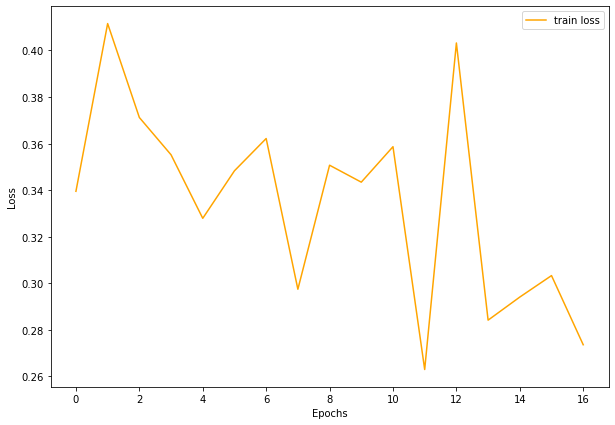

In [84]:
"""
# accuracy plots
plt.figure(figsize = (10, 7))
plt.plot(Test_acc, color = 'green', label = 'test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../DeepLearningProjectNew/models/test accuracy.png')
plt.show()
"""
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(loss_array, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../DeepLearningProjectNew/models/Train_Loss.png')
plt.show()  

End of CNN Module Start of Resnet Module

'Quadro M4000'

In [85]:
def weights(device,train_df):    
    weights = compute_class_weight(y=train_df.target.values, class_weight = "balanced", classes = train_df.target.unique())    
    class_weights = torch.FloatTensor(weights)
    if device.type == "cuda":
        class_weights = class_weights.cuda()
    print(class_weights)
    train_df.target.unique()
    return class_weights

In [86]:
model_resnet = torchvision.models.resnet18(pretrained=False)
#if run_training:
#    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model_resnet.fc.in_features
print(num_features)

model_resnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model_resnet.apply(init_weights)
model_resnet = model_resnet.to(device)

512


In [87]:
class_weights = weights(device,train_cnn)
print(class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adamax(model_resnet.fc.parameters()) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

tensor([0.6982, 1.7612], device='cuda:0')
tensor([0.6982, 1.7612], device='cuda:0')


In [91]:
loss_array_RESNET = train_model(NUM_EPOCHS_RESNET,learning_rate_RESNET,loader_train,optimizer,criterion,model_resnet)

Train started:


  6%|▌         | 100/1734 [02:15<40:31,  1.49s/it]

Epoch [1/1], Step [100/1734], Loss: 0.6780, time:2.2555014292399087 min


 12%|█▏        | 200/1734 [04:30<36:12,  1.42s/it]

Epoch [1/1], Step [200/1734], Loss: 0.5759, time:4.515127793947856 min


 17%|█▋        | 300/1734 [06:46<33:14,  1.39s/it]

Epoch [1/1], Step [300/1734], Loss: 0.4355, time:6.771347669760386 min


 23%|██▎       | 400/1734 [08:59<34:08,  1.54s/it]

Epoch [1/1], Step [400/1734], Loss: 0.5054, time:8.999177141984303 min


 29%|██▉       | 500/1734 [11:12<29:08,  1.42s/it]

Epoch [1/1], Step [500/1734], Loss: 0.4580, time:11.203761724630992 min


 35%|███▍      | 600/1734 [13:26<26:30,  1.40s/it]

Epoch [1/1], Step [600/1734], Loss: 0.4342, time:13.446462496121724 min


 40%|████      | 700/1734 [15:39<25:33,  1.48s/it]

Epoch [1/1], Step [700/1734], Loss: 0.6184, time:15.654395202795664 min


 46%|████▌     | 800/1734 [17:53<23:34,  1.51s/it]

Epoch [1/1], Step [800/1734], Loss: 0.4892, time:17.89206436475118 min


 52%|█████▏    | 900/1734 [20:05<19:41,  1.42s/it]

Epoch [1/1], Step [900/1734], Loss: 0.4796, time:20.09725438753764 min


 58%|█████▊    | 1000/1734 [22:17<19:08,  1.56s/it]

Epoch [1/1], Step [1000/1734], Loss: 0.3903, time:22.289824787775675 min


 63%|██████▎   | 1100/1734 [24:26<15:24,  1.46s/it]

Epoch [1/1], Step [1100/1734], Loss: 0.4515, time:24.436484150091808 min


 69%|██████▉   | 1200/1734 [26:32<12:13,  1.37s/it]

Epoch [1/1], Step [1200/1734], Loss: 0.4742, time:26.54242772658666 min


 75%|███████▍  | 1300/1734 [28:40<09:35,  1.33s/it]

Epoch [1/1], Step [1300/1734], Loss: 0.5174, time:28.668705821037292 min


 81%|████████  | 1400/1734 [30:46<07:34,  1.36s/it]

Epoch [1/1], Step [1400/1734], Loss: 0.3894, time:30.778592852751412 min


 87%|████████▋ | 1500/1734 [32:54<04:54,  1.26s/it]

Epoch [1/1], Step [1500/1734], Loss: 0.4010, time:32.91647354364395 min


 92%|█████████▏| 1600/1734 [35:07<02:56,  1.32s/it]

Epoch [1/1], Step [1600/1734], Loss: 0.3895, time:35.12896774609884 min


 98%|█████████▊| 1700/1734 [37:16<00:48,  1.44s/it]

Epoch [1/1], Step [1700/1734], Loss: 0.3429, time:37.27231883605321 min


100%|██████████| 1734/1734 [37:59<00:00,  1.31s/it]


In [92]:
Test_acc, confusion_matrix = Test_model(model_resnet)

100%|██████████| 868/868 [08:42<00:00,  1.66it/s]


79.79281145842717
tensor([[31047.,  8701.],
        [ 2515., 13242.]])


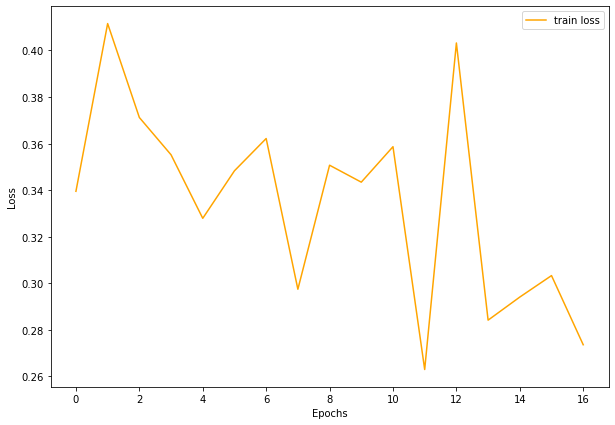

In [93]:
print(Test_acc)
print(confusion_matrix)
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(loss_array, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../DeepLearningProjectNew/models/Train_Loss.png')
plt.show()  

In [97]:
model_resnet2 = torchvision.models.resnet50(pretrained=False)
#model_resnet2.load_state_dict(torch.load("input/breastcancermodel/resnet50-19c8e357.pth"))
num_features = model_resnet2.fc.in_features
print("Number of features:"+str(num_features))
model_resnet2.fc = nn.Sequential(
           nn.Linear(num_features, 512),
           nn.ReLU(),
           nn.BatchNorm1d(512),
           nn.Dropout(0.25),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.BatchNorm1d(256),
           nn.Dropout(0.25),
           nn.Linear(256, 128),
           nn.ReLU(),
           nn.BatchNorm1d(128),
           nn.Dropout(0.25),
           nn.Linear(128, 64),
           nn.ReLU(),
           nn.BatchNorm1d(64),
           nn.Dropout(0.25),
           nn.Linear(64, 32),
           nn.ReLU(),
           nn.BatchNorm1d(32),
           nn.Dropout(0.25),
           nn.Linear(32, 16),
           nn.ReLU(),
           nn.BatchNorm1d(16),
           nn.Dropout(0.25),
           nn.Linear(16, 8),
           nn.ReLU(),
           nn.BatchNorm1d(8),
           nn.Dropout(0.25),
           nn.Linear(8, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model_resnet2.apply(init_weights)
model_resnet2 = model_resnet2.to(device)


Number of features:2048


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.94 GiB total capacity; 7.12 GiB already allocated; 640.00 KiB free; 7.16 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [181]:
#torch.cuda.empty_cache() 

In [95]:
# Create resnet model
#model_resnet2 = model50(NUM_CLASSES)

Number of features:2048


In [96]:
loss_array_RESNET2 = train_model(NUM_EPOCHS_RESNET,learning_rate_RESNET,loader_train,optimizer,criterion,model_resnet2)

Train started:


  0%|          | 0/1734 [00:02<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 7.94 GiB total capacity; 7.10 GiB already allocated; 12.62 MiB free; 7.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(Test_acc)
print(confusion_matrix)
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(loss_array, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../DeepLearningProjectNew/models/Train_Loss.png')
plt.show()  

In [ ]:
# Test the model
def Test_model_majority_vote(model_resnet, model_resnet2, model_cnn):
    model_Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        tk0 = tqdm(loader_test, total=int(len(loader_test)))
        for filename, target in tk0:
            filename = filename.to(device)
            target = target.to(device)
            outputs_cnn = model_Cnn(filename)
            outputs_resnet = model_resnet(filename)
            outputs_resnet2 = model_resnet2(filename) 
            temp, predicted_cnn = torch.max(outputs_cnn.data, 1)
            temp, predicted_resnet = torch.max(outputs_resnet.data, 1) 
            temp, predicted_resnet2 = torch.max(outputs_resnet2.data, 1)
            predicted = round((predicted_cnn + predicted_resnet + predicted_resnet2) / 3)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)    
    return Test_acc, confusion_matrix   

In [ ]:
Test_acc, confusion_matrix = Test_model_majority_vote(model_resnet, model_resnet2, model_cnn)

In [ ]:
print(Test_acc)
print(confusion_matrix)